# Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/markean/aimz/blob/main/docs/notebooks/tutorial.ipynb)

This guide demonstrates a minimal end-to-end workflow with `ImpactModel` for a binary outcome model using a Bayesian neural network.
The process involves simulating data, setting up a neural network, fitting the model via stochastic variational inference (SVI), and generating posterior predictive samples for downstream summaries or evaluation.

## Synthetic Dataset

A synthetic binary outcome dataset is generated.
A random weight vector `beta` defines the linear logit signal; applying the sigmoid to `X @ beta` yields the true success probabilities, and a Bernoulli draw produces the binary labels `y`.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from flax import nnx
from jax import Array, default_backend, random
from jax.typing import ArrayLike
from numpyro import deterministic, plate, sample
from numpyro.contrib.module import random_nnx_module
from numpyro.infer import SVI, Trace_ELBO, init_to_uniform
from numpyro.infer.autoguide import AutoNormal
from optax import adam

from aimz import ImpactModel

%config InlineBackend.figure_format = "retina"

%load_ext watermark

n = 1_000_000
d = 100
rng_key = random.key(0)
rng_key, rng_subkey_X, rng_subkey_beta, rng_subkey_y = random.split(rng_key, 4)
X = random.normal(rng_subkey_X, (n, d))
beta = random.normal(rng_subkey_beta, (d,))
logits = X @ beta
p_true = nnx.sigmoid(logits)
y = random.bernoulli(rng_subkey_y, p_true).astype(jnp.int32)

## Model Specification
Three fully connected layers with ReLU activations followed by a sigmoid define the neural network used as the kernel of the `ImpactModel`.
The `plate("data", ...)` construct enables efficient minibatch SVI via subsampling, scaling inference to large datasets.
A deterministic site `p` records the per‑observation probabilities so posterior predictive methods can return them directly without rerunning the forward pass.


In [2]:
class MLP(nnx.Module):
    dtype: jnp.dtype = jnp.bfloat16 if default_backend() == "gpu" else jnp.float32

    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs) -> None:
        self.linear1 = nnx.Linear(din, dmid, dtype=self.dtype, rngs=rngs)
        self.linear2 = nnx.Linear(dmid, dmid, dtype=self.dtype, rngs=rngs)
        self.linear3 = nnx.Linear(dmid, dout, dtype=self.dtype, rngs=rngs)

    def __call__(self, x: ArrayLike) -> Array:
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        x = nnx.relu(x)
        x = self.linear3(x)

        return nnx.sigmoid(x).squeeze()


rng_key, rng_subkey = random.split(rng_key)
p_nn_module = MLP(
    din=X.shape[1],
    dmid=32,
    dout=1,
    rngs=nnx.Rngs(params=rng_subkey),
)


def model(X: ArrayLike, *, y: ArrayLike | None = None) -> None:
    nn_p = random_nnx_module(
        "nn_p",
        nn_module=p_nn_module,
        scope_divider="_",
        prior=dist.Normal(),
    )
    with plate("data", size=n, subsample_size=len(X)):
        p = nn_p(X)
        deterministic("p", p)
        sample("y", dist.Bernoulli(p), obs=y)

The `ImpactModel` encapsulates the model and provides a unified API for fitting, sampling, posterior and posterior predictive generation, effect estimation, and diagnostics.
Initialization requires the model callable (the kernel), a JAX pseudo-random number generator key (`rng_key`), and an `inference` object (here an `SVI` configured with a guide, optimizer, and ELBO loss).
During initialization, available accelerators (CPU/GPU) are automatically detected and registered, and the internal PRNG state is seeded for subsequent calls.

In [3]:
rng_key, rng_subkey = random.split(key=rng_key)
im = ImpactModel(
    model,
    rng_key=rng_subkey,
    inference=SVI(
        model,
        guide=AutoNormal(model=model, init_loc_fn=init_to_uniform(radius=0.1)),
        optim=adam(learning_rate=1e-3),
        loss=Trace_ELBO(),
    ),
)

Backend: cpu, Devices: 1


## Training
The `.fit()` method performs mini‑batch SVI updates of the variational parameters.
After optimization it automatically draws posterior samples using the configured guide.
The SVI results are stored in the `vi_result` attribute of the `ImpactModel` instance, including the optimized variational parameters and ELBO loss history.

Performing variational inference optimization...
Epoch 1/10 - Average loss: 363374.9688
Epoch 2/10 - Average loss: 176024.9688
Epoch 3/10 - Average loss: 161907.0312
Epoch 4/10 - Average loss: 155316.0625
Epoch 5/10 - Average loss: 151910.7969
Epoch 6/10 - Average loss: 148961.6875
Epoch 7/10 - Average loss: 147467.0781
Epoch 8/10 - Average loss: 146256.3125
Epoch 9/10 - Average loss: 145001.6250
Epoch 10/10 - Average loss: 144211.0781
Posterior sampling...


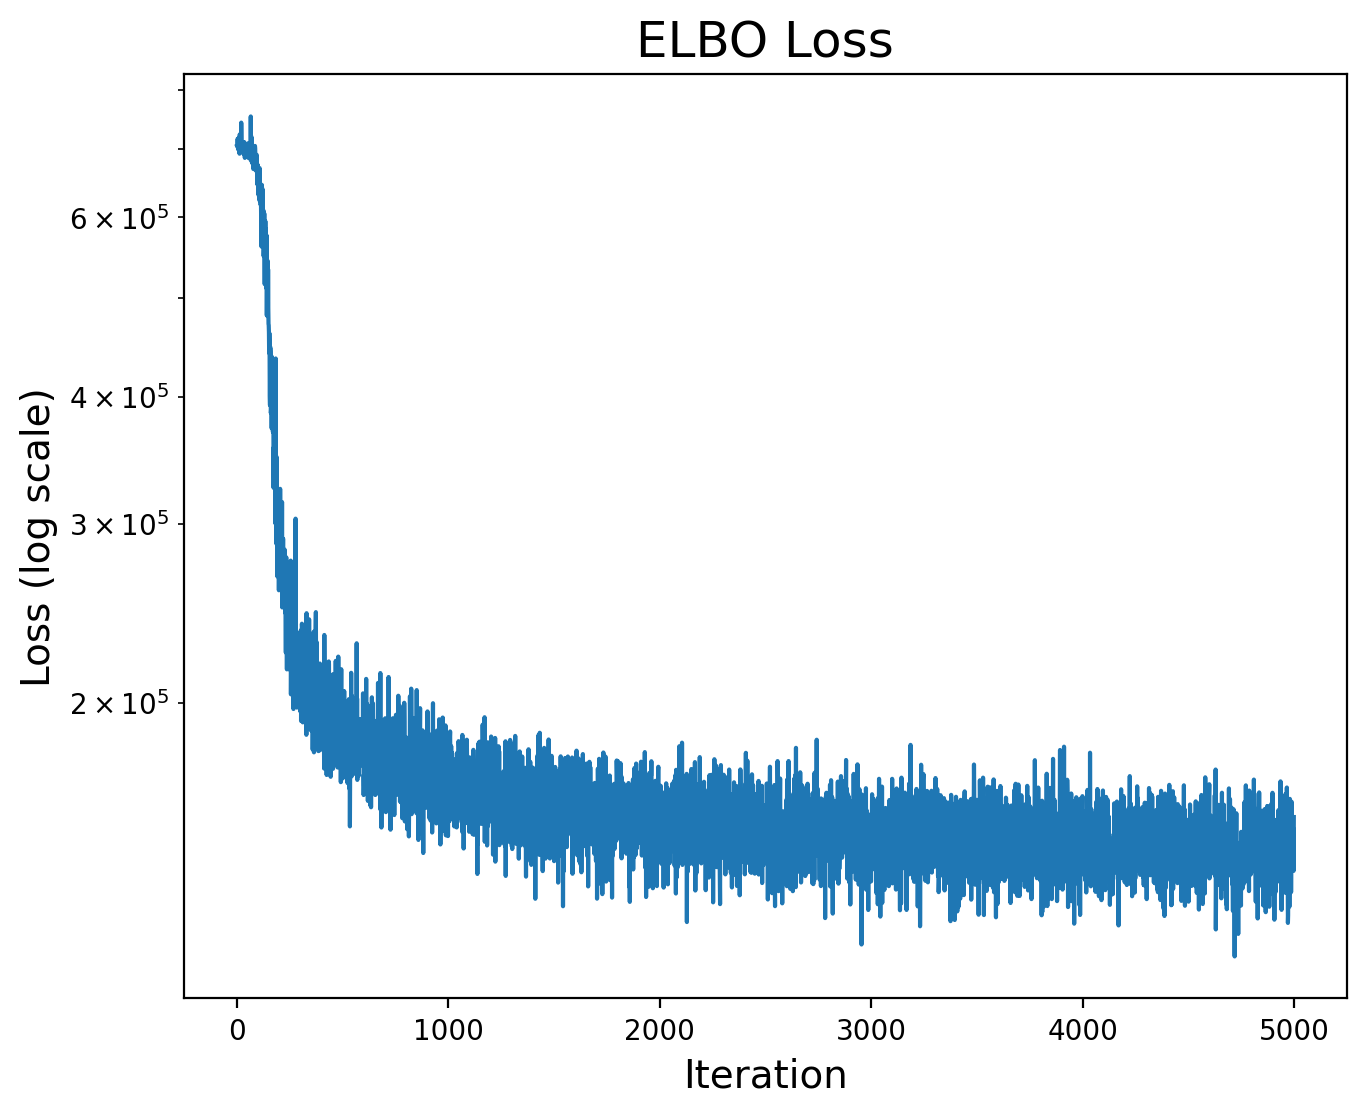

In [4]:
im.fit(X, y, num_samples=500, batch_size=2000, epochs=10, progress=False)

fig, ax = plt.subplots(figsize=(7.5, 6))
ax.plot(im.vi_result.losses)
ax.set(yscale="log")
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Loss (log scale)", fontsize=14)
ax.set_title("ELBO Loss", fontsize=18);

## Inference

Prediction and posterior predictive sampling are performed with `.predict()`, which streams input batches to produce predictive draws.
Computation is JIT-compiled and automatically sharded across available devices, while sampling and disk writes run concurrently with results saved incrementally in Zarr format.

The `batch_size` parameter controls per‑step memory footprint and the chunk size of stored arrays.
The `output_dir` parameter specifies where timestamped subdirectories are created; if omitted, a model‑scoped temporary directory is allocated.
Interventions (do-operations) are passed via the `intervention` argument and applied with NumPyro's `do` effect handler, enabling structural graph surgery without modifying the original kernel.
The return value is an `DataTree`.

In [5]:
dt = im.predict(X, batch_size=100_000)
dt

Temporary directory created at: /var/folders/pd/0fwrc7d570b2p215vhytph0w0000gp/T/tmp1djg6f_b
No output directory provided. Using the model's temporary directory for storing output.


Posterior predictive sampling [y, p]:   0%|          | 0/10 [00:00<?, ?it/s]

<xarray.DataTree 'root'>
Group: /
│   Attributes:
│       output_dir:  /private/var/folders/pd/0fwrc7d570b2p215vhytph0w0000gp/T/tmp...
├── Group: /posterior
│       Dimensions:                    (chain: 1, draw: 500,
│                                       nn_p_linear1.bias_dim_0: 32,
│                                       nn_p_linear1.kernel_dim_0: 100,
│                                       nn_p_linear1.kernel_dim_1: 32,
│                                       nn_p_linear2.bias_dim_0: 32,
│                                       nn_p_linear2.kernel_dim_0: 32,
│                                       nn_p_linear2.kernel_dim_1: 32,
│                                       nn_p_linear3.bias_dim_0: 1,
│                                       nn_p_linear3.kernel_dim_0: 32,
│                                       nn_p_linear3.kernel_dim_1: 1)
│       Coordinates:
│         * chain                      (chain) int64 8B 0
│         * draw                       (draw) int64 4kB 0 1 2 3 4 ... 496 497 498 499
│         * nn_p_linear1.bias_dim_0    (nn_p_linear1.bias_dim_0) int64 256B 0 1 ... 31
│         * nn_p_linear1.kernel_dim_0  (nn_p_linear1.kernel_dim_0) int64 800B 0 1 ... 99
│         * nn_p_linear1.kernel_dim_1  (nn_p_linear1.kernel_dim_1) int64 256B 0 1 ... 31
│         * nn_p_linear2.bias_dim_0    (nn_p_linear2.bias_dim_0) int64 256B 0 1 ... 31
│         * nn_p_linear2.kernel_dim_0  (nn_p_linear2.kernel_dim_0) int64 256B 0 1 ... 31
│         * nn_p_linear2.kernel_dim_1  (nn_p_linear2.kernel_dim_1) int64 256B 0 1 ... 31
│         * nn_p_linear3.bias_dim_0    (nn_p_linear3.bias_dim_0) int64 8B 0
│         * nn_p_linear3.kernel_dim_0  (nn_p_linear3.kernel_dim_0) int64 256B 0 1 ... 31
│         * nn_p_linear3.kernel_dim_1  (nn_p_linear3.kernel_dim_1) int64 8B 0
│       Data variables:
│           nn_p_linear1.bias          (chain, draw, nn_p_linear1.bias_dim_0) float32 64kB ...
│           nn_p_linear1.kernel        (chain, draw, nn_p_linear1.kernel_dim_0, nn_p_linear1.kernel_dim_1) float32 6MB ...
│           nn_p_linear2.bias          (chain, draw, nn_p_linear2.bias_dim_0) float32 64kB ...
│           nn_p_linear2.kernel        (chain, draw, nn_p_linear2.kernel_dim_0, nn_p_linear2.kernel_dim_1) float32 2MB ...
│           nn_p_linear3.bias          (chain, draw, nn_p_linear3.bias_dim_0) float32 2kB ...
│           nn_p_linear3.kernel        (chain, draw, nn_p_linear3.kernel_dim_0, nn_p_linear3.kernel_dim_1) float32 64kB ...
│       Attributes:
│           created_at:    2025-09-27T19:40:53.299917+00:00
│           aimz_version:  0.7.0
└── Group: /posterior_predictive
        Dimensions:  (chain: 1, draw: 500, p_dim_0: 1000000, y_dim_0: 1000000)
        Coordinates:
          * chain    (chain) int64 8B 0
          * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
          * p_dim_0  (p_dim_0) int64 8MB 0 1 2 3 4 ... 999996 999997 999998 999999
          * y_dim_0  (y_dim_0) int64 8MB 0 1 2 3 4 ... 999996 999997 999998 999999
        Data variables:
            p        (chain, draw, p_dim_0) float32 2GB dask.array<chunksize=(1, 500, 100000), meta=np.ndarray>
            y        (chain, draw, y_dim_0) int32 2GB dask.array<chunksize=(1, 500, 100000), meta=np.ndarray>
        Attributes:
            created_at:    2025-09-27T19:40:53.296968+00:00
            aimz_version:  0.7.0
            output_dir:    /private/var/folders/pd/0fwrc7d570b2p215vhytph0w0000gp/T/t...

When no explicit `output_dir` is provided, a temporary directory is created lazily and is automatically removed when the `ImpactModel` instance is finalized (object destruction).
Calling `.cleanup()` is optional but recommended for deterministic early release of disk resources, particularly in long-running kernels.
If an explicit `output_dir` was supplied or the directory has already been removed, the method performs no action.

In [6]:
im.cleanup()

Temporary directory cleaned up at: /var/folders/pd/0fwrc7d570b2p215vhytph0w0000gp/T/tmp1djg6f_b


In [7]:
%watermark -iv

flax      : 0.12.0
matplotlib: 3.10.6
jax       : 0.7.2
optax     : 0.2.6
numpyro   : 0.19.0
aimz      : 0.7.0

